In [1]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
from IPython.display import Video

def show_video(video):
    fig = plt.figure()
    im = plt.imshow(video[0,:,:,:])
    plt.close() # this is required to not display the generated image

    def init_video():
        im.set_data(video[0,:,:,:])

    def animate_video(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate_video, init_func=init_video, frames=video.shape[0],
                               interval=50)
    display(HTML(anim.to_html5_video()))

In [3]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
    """Lists videos available in UCF101 dataset."""
    global _VIDEO_LIST
    if not _VIDEO_LIST:
        index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
        videos = re.findall("(v_[\w_]+\.avi)", index)
        _VIDEO_LIST = sorted(set(videos))
    return list(_VIDEO_LIST)

def fetch_ucf_video(video):
    """Fetchs a video and cache into local filesystem."""
    cache_path = os.path.join(_CACHE_DIR, video)
    if not os.path.exists(cache_path):
        urlpath = request.urljoin(UCF_ROOT, video)
        print("Fetching %s => %s" % (urlpath, cache_path))
        data = request.urlopen(urlpath, context=unverified_context).read()
        open(cache_path, "wb").write(data)
    return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
      
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) / 255.0

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    return embed.embed_file('./animation.gif')

In [4]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
    labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [5]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
    category = video[2:-12]
    if category not in categories:
        categories[category] = []
    categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
    summary = ", ".join(sequences[:2])
    print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))

Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

In [6]:
# Get a sample cricket video.
cat = "v_GolfSwing_g01_c01" + ".avi"
video_path = fetch_ucf_video(cat)
sample_video = load_video(video_path)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_GolfSwing_g01_c01.avi => /var/folders/q2/v8n1vs615dzc6zx7jy46tkw80000gn/T/tmpq1mjlt0n/v_GolfSwing_g01_c01.avi


In [7]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

2022-02-08 15:20:04.767614: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [8]:
def predict(sample_video):
    # Add a batch axis to the sample video.
    model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

    logits = i3d(model_input)['default'][0]
    probabilities = tf.nn.softmax(logits)

    print("Top 5 actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%, label: {i}")

## Original

<IPython.core.display.Javascript object>


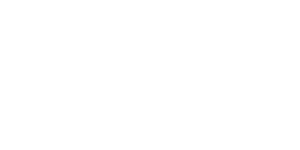

Top 5 actions:
  golf driving          : 78.77%, label: 142
  shot put              :  6.63%, label: 298
  hammer throw          :  6.57%, label: 148
  throwing discus       :  3.56%, label: 358
  yoga                  :  2.47%, label: 398


In [9]:
show_video(sample_video)
predict(sample_video)

## Freeze

<IPython.core.display.Javascript object>


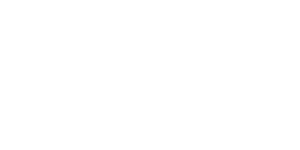

Top 5 actions:
  yoga                  : 29.87%, label: 398
  stretching leg        : 23.75%, label: 334
  golf driving          : 10.83%, label: 142
  stretching arm        :  5.70%, label: 333
  lunge                 :  5.66%, label: 183


In [10]:
frames, _, _, _ = sample_video.shape
only_frame1 = np.tile(np.expand_dims(sample_video[frames // 2], 0), (frames, 1, 1, 1))
show_video(only_frame1)
predict(only_frame1)

## Reverse

<IPython.core.display.Javascript object>


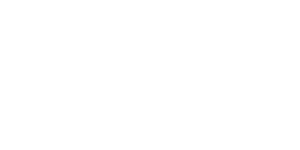

Top 5 actions:
  golf driving          : 78.77%, label: 142
  shot put              :  6.63%, label: 298
  hammer throw          :  6.57%, label: 148
  throwing discus       :  3.56%, label: 358
  yoga                  :  2.47%, label: 398


In [11]:
reverse = np.flip(sample_video, axis=0)
show_video(reverse)
predict(sample_video)

## Shuffle Frames

<IPython.core.display.Javascript object>


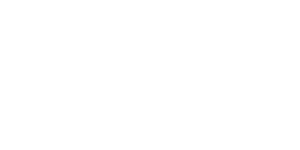

Top 5 actions:
  cleaning pool         : 24.56%, label: 62
  texting               : 14.25%, label: 355
  brush painting        : 12.70%, label: 35
  hammer throw          :  7.80%, label: 148
  golf driving          :  4.32%, label: 142


In [12]:
shuffled = np.copy(sample_video)
np.random.shuffle(shuffled)
show_video(shuffled)
predict(shuffled)

## Shuffle Patches

In [11]:
import torch
import torch.nn.functional as nnf

class ShufflePatches(object):
    def patchify(self, x, ps):
        x = torch.from_numpy(x).permute(0, 3, 1, 2)
        # divide the batch of images into non-overlapping patches
        u = nnf.unfold(x, kernel_size=ps, stride=ps, padding=0)
        # permute the patches of each image in the batch
        indices = torch.randperm(u.shape[-1])
        pu = u[:, :, indices]
        # fold the permuted patches back together
        f = nnf.fold(pu, x.shape[-2:], kernel_size=ps, stride=ps, padding=0).permute(0, 2, 3, 1).numpy()
        return f

<IPython.core.display.Javascript object>


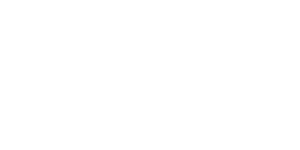

Top 5 actions:
  golf driving          : 32.49%, label: 142
  cleaning windows      : 15.85%, label: 65
  pumping gas           :  5.95%, label: 257
  hammer throw          :  3.13%, label: 148
  laying bricks         :  2.01%, label: 181


In [12]:
shuffler = ShufflePatches()
patch_112 = shuffler.patchify(sample_video, 56)
show_video(patch_112)
predict(patch_112)

## Kornia Augmentations

In [13]:
import kornia
factor = 0.7

## Brightness

<IPython.core.display.Javascript object>


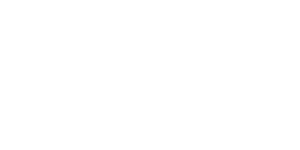

Top 5 actions:
  golf driving          : 82.52%, label: 142
  golf chipping         : 10.29%, label: 141
  yoga                  :  2.99%, label: 398
  hammer throw          :  0.48%, label: 148
  stretching leg        :  0.43%, label: 334


In [14]:
video = kornia.enhance.adjust_brightness(torch.from_numpy(sample_video).unsqueeze(0).permute(0, 1, 4, 2, 3), 0.7)
video = video.permute(0, 1, 3, 4, 2).squeeze(0).numpy()
video = (video - np.min(video)) / (np.max(video) - np.min(video))
show_video(video)
predict(video)

## Hue

<IPython.core.display.Javascript object>


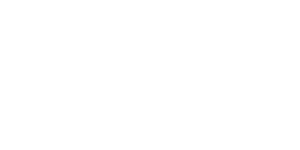

Top 5 actions:
  golf driving          : 51.13%, label: 142
  hammer throw          : 33.60%, label: 148
  throwing discus       :  8.16%, label: 358
  javelin throw         :  3.63%, label: 166
  shot put              :  1.20%, label: 298


In [15]:
video = kornia.enhance.adjust_hue(torch.from_numpy(sample_video).unsqueeze(0).permute(0, 1, 4, 2, 3), -2.5)
video = video.permute(0, 1, 3, 4, 2).squeeze(0).numpy()
video = (video - np.min(video)) / (np.max(video) - np.min(video))
show_video(video)
predict(video)

## Saturation

<IPython.core.display.Javascript object>


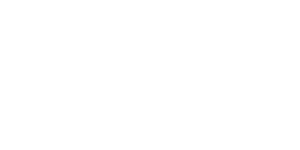

Top 5 actions:
  hammer throw          : 25.25%, label: 148
  shot put              : 22.89%, label: 298
  golf driving          : 15.79%, label: 142
  throwing discus       : 14.84%, label: 358
  hula hooping          : 10.26%, label: 159


In [16]:
video = kornia.enhance.adjust_saturation(torch.from_numpy(sample_video).unsqueeze(0).permute(0, 1, 4, 2, 3), 1 - 0.8)
video = video.permute(0, 1, 3, 4, 2).squeeze(0).numpy()
video = (video - np.min(video)) / (np.max(video) - np.min(video))
show_video(video)
predict(video)

## Posterize

<IPython.core.display.Javascript object>


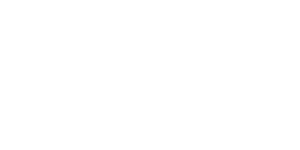

Top 5 actions:
  golf driving          : 76.17%, label: 142
  hammer throw          : 16.78%, label: 148
  throwing discus       :  2.64%, label: 358
  yoga                  :  1.88%, label: 398
  shot put              :  1.30%, label: 298


In [17]:
video = kornia.enhance.posterize(torch.from_numpy(sample_video).unsqueeze(0).permute(0, 1, 4, 2, 3), bits=3)
video = video.permute(0, 1, 3, 4, 2).squeeze(0).numpy()
video = (video - np.min(video)) / (np.max(video) - np.min(video))
show_video(video)
predict(video)

## Clahe

<IPython.core.display.Javascript object>


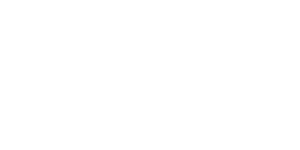

Top 5 actions:
  golf driving          : 98.52%, label: 142
  hammer throw          :  0.59%, label: 148
  hula hooping          :  0.52%, label: 159
  golf chipping         :  0.17%, label: 141
  golf putting          :  0.09%, label: 143


In [18]:
video = kornia.enhance.equalize_clahe(torch.from_numpy(sample_video).unsqueeze(0).permute(0, 1, 4, 2, 3))
video = video.permute(0, 1, 3, 4, 2).squeeze(0).numpy()
video = (video - np.min(video)) / (np.max(video) - np.min(video))
show_video(video)
predict(video)

## Solarize

<IPython.core.display.Javascript object>


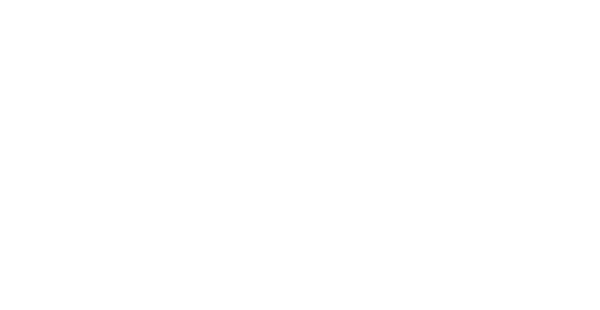

Top 5 actions:
  golf driving          : 93.14%, label: 142
  golf chipping         :  3.04%, label: 141
  yoga                  :  1.05%, label: 398
  stretching leg        :  0.72%, label: 334
  hammer throw          :  0.44%, label: 148


In [19]:
video = kornia.enhance.solarize(torch.from_numpy(sample_video).unsqueeze(0).permute(0, 1, 4, 2, 3))
video = video.permute(0, 1, 3, 4, 2).squeeze(0).numpy()
video = (video - np.min(video)) / (np.max(video) - np.min(video))
show_video(video)
predict(video)